In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class ALPNet(nn.Module):
    def __init__(self, input_size, num_classes, base_channels=32, expansion_factor=2):
        super(ALPNet, self).__init__()
        self.base_channels = base_channels
        self.expansion_factor = expansion_factor
        sequence_length = input_size // 3

        def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm1d(out_channels),
                nn.SiLU(inplace=True)
            )

        def separable_conv(in_channels, out_channels, stride=1):
            return nn.Sequential(
                nn.Conv1d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False),
                nn.BatchNorm1d(in_channels),
                nn.SiLU(inplace=True),
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(out_channels)
            )

        self.prep = conv_block(3, self.base_channels, kernel_size=5, stride=2, padding=2)

        self.layer1 = nn.Sequential(
            separable_conv(self.base_channels, self.base_channels * self.expansion_factor, stride=1),
            nn.SiLU(inplace=True),
            nn.Dropout(0.3),
            separable_conv(self.base_channels * self.expansion_factor, self.base_channels * self.expansion_factor, stride=1),
            nn.SiLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            separable_conv(self.base_channels * self.expansion_factor, self.base_channels * 2 * self.expansion_factor, stride=2),
            nn.SiLU(inplace=True),
            nn.Dropout(0.3),
            separable_conv(self.base_channels * 2 * self.expansion_factor, self.base_channels * 2 * self.expansion_factor, stride=1),
            nn.SiLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            separable_conv(self.base_channels * 2 * self.expansion_factor, self.base_channels * 4 * self.expansion_factor, stride=2),
            nn.SiLU(inplace=True),
            nn.Dropout(0.3),
            separable_conv(self.base_channels * 4 * self.expansion_factor, self.base_channels * 4 * self.expansion_factor, stride=1),
            nn.SiLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.6) # Increased dropout here
        self.fc = nn.Linear(1, num_classes) # Placeholder, will be updated

        # --- DEBUGGING FORWARD PASS ---
        with torch.no_grad():
            dummy_input = torch.randn(1, input_size)
            x = dummy_input.view(1, 3, -1)
            x = self.prep(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            self._flattened_size = x.flatten().shape[0]
            print(f"Calculated flattened size: {self._flattened_size}")
            # Update the FC layer with the correct input size
            self.fc = nn.Linear(self._flattened_size, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 3, -1)

        x = self.prep(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [3]:
# --- Data Loading and Preprocessing ---
class WoundDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(class_dir, filename))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label, os.path.basename(img_path)

In [4]:
# --- Hyperparameters ---
input_size = 224 * 224 * 3 # Example: flatten image of 224x224x3
num_classes = 2
batch_size = 32
learning_rate = 0.001
num_epochs = 20
validation_split = 0.2

# --- Data Transformations ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# --- Load Dataset and Split ---
wound_data_dir = 'wound_data'
dataset = WoundDataset(root_dir=wound_data_dir, transform=transform)
train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=validation_split, stratify=dataset.labels, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [6]:
# --- Initialize Model, Loss, and Optimizer ---
model = ALPNet(input_size=input_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001) # Added weight decay

Calculated flattened size: 200704


In [7]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ALPNet(
  (prep): Sequential(
    (0): Conv1d(3, 32, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Sequential(
      (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), groups=32, bias=False)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
      (3): Conv1d(32, 64, kernel_size=(1,), stride=(1,), bias=False)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SiLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), groups=64, bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
      (3): Conv1d(64, 64, kernel_size=(1

In [8]:
# --- Training Loop ---

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, (inputs, labels, _) in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        train_loss = running_loss / total_samples
        train_accuracy = correct_predictions / total_samples
        progress_bar.set_postfix(loss=train_loss, accuracy=train_accuracy)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # --- Validation Loop ---
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0
    with torch.no_grad():
        for inputs, labels, _ in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_samples += labels.size(0)

    val_loss = val_running_loss / val_total_samples
    val_accuracy = val_correct_predictions / val_total_samples
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")


Epoch 1/20: 100%|██████████| 11/11 [00:56<00:00,  5.13s/it, accuracy=0.555, loss=18.7]


Epoch 1 - Train Loss: 18.6597, Train Acc: 0.5552, Val Loss: 0.7433, Val Acc: 0.6667


Epoch 2/20: 100%|██████████| 11/11 [00:55<00:00,  5.01s/it, accuracy=0.587, loss=8.68]


Epoch 2 - Train Loss: 8.6766, Train Acc: 0.5872, Val Loss: 7.8564, Val Acc: 0.3333


Epoch 3/20: 100%|██████████| 11/11 [00:54<00:00,  4.99s/it, accuracy=0.593, loss=4.99]


Epoch 3 - Train Loss: 4.9931, Train Acc: 0.5930, Val Loss: 0.8783, Val Acc: 0.6782


Epoch 4/20: 100%|██████████| 11/11 [00:55<00:00,  5.03s/it, accuracy=0.698, loss=1.78]


Epoch 4 - Train Loss: 1.7840, Train Acc: 0.6977, Val Loss: 0.9922, Val Acc: 0.6552


Epoch 5/20: 100%|██████████| 11/11 [00:55<00:00,  5.02s/it, accuracy=0.805, loss=0.884]


Epoch 5 - Train Loss: 0.8842, Train Acc: 0.8052, Val Loss: 0.5699, Val Acc: 0.8046


Epoch 6/20: 100%|██████████| 11/11 [00:54<00:00,  5.00s/it, accuracy=0.762, loss=0.813]


Epoch 6 - Train Loss: 0.8128, Train Acc: 0.7616, Val Loss: 0.9506, Val Acc: 0.6897


Epoch 7/20: 100%|██████████| 11/11 [00:55<00:00,  5.02s/it, accuracy=0.802, loss=0.625]


Epoch 7 - Train Loss: 0.6250, Train Acc: 0.8023, Val Loss: 0.6652, Val Acc: 0.7241


Epoch 8/20: 100%|██████████| 11/11 [00:43<00:00,  3.99s/it, accuracy=0.799, loss=0.651]


Epoch 8 - Train Loss: 0.6510, Train Acc: 0.7994, Val Loss: 1.0337, Val Acc: 0.7816


Epoch 9/20: 100%|██████████| 11/11 [00:04<00:00,  2.62it/s, accuracy=0.788, loss=0.671]


Epoch 9 - Train Loss: 0.6711, Train Acc: 0.7878, Val Loss: 1.2537, Val Acc: 0.6322


Epoch 10/20: 100%|██████████| 11/11 [00:04<00:00,  2.29it/s, accuracy=0.834, loss=0.519]


Epoch 10 - Train Loss: 0.5187, Train Acc: 0.8343, Val Loss: 1.0341, Val Acc: 0.7011


Epoch 11/20: 100%|██████████| 11/11 [00:55<00:00,  5.04s/it, accuracy=0.858, loss=0.422]


Epoch 11 - Train Loss: 0.4221, Train Acc: 0.8576, Val Loss: 1.0508, Val Acc: 0.7126


Epoch 12/20: 100%|██████████| 11/11 [00:55<00:00,  5.04s/it, accuracy=0.863, loss=0.381]


Epoch 12 - Train Loss: 0.3813, Train Acc: 0.8634, Val Loss: 1.1035, Val Acc: 0.7586


Epoch 13/20: 100%|██████████| 11/11 [00:55<00:00,  5.06s/it, accuracy=0.892, loss=0.302]


Epoch 13 - Train Loss: 0.3018, Train Acc: 0.8924, Val Loss: 0.9674, Val Acc: 0.7356


Epoch 14/20: 100%|██████████| 11/11 [00:55<00:00,  5.06s/it, accuracy=0.936, loss=0.171]


Epoch 14 - Train Loss: 0.1714, Train Acc: 0.9360, Val Loss: 1.7008, Val Acc: 0.7356


Epoch 15/20: 100%|██████████| 11/11 [00:55<00:00,  5.04s/it, accuracy=0.881, loss=0.449]


Epoch 15 - Train Loss: 0.4486, Train Acc: 0.8808, Val Loss: 1.4092, Val Acc: 0.7011


Epoch 16/20: 100%|██████████| 11/11 [00:55<00:00,  5.05s/it, accuracy=0.866, loss=0.321]


Epoch 16 - Train Loss: 0.3210, Train Acc: 0.8663, Val Loss: 1.2173, Val Acc: 0.7356


Epoch 17/20: 100%|██████████| 11/11 [00:55<00:00,  5.05s/it, accuracy=0.904, loss=0.289]


Epoch 17 - Train Loss: 0.2892, Train Acc: 0.9041, Val Loss: 1.2023, Val Acc: 0.7356


Epoch 18/20: 100%|██████████| 11/11 [00:21<00:00,  1.97s/it, accuracy=0.895, loss=0.378]


Epoch 18 - Train Loss: 0.3785, Train Acc: 0.8953, Val Loss: 1.8013, Val Acc: 0.7126


Epoch 19/20: 100%|██████████| 11/11 [00:20<00:00,  1.83s/it, accuracy=0.91, loss=0.306] 


Epoch 19 - Train Loss: 0.3060, Train Acc: 0.9099, Val Loss: 1.6298, Val Acc: 0.7471


Epoch 20/20: 100%|██████████| 11/11 [00:55<00:00,  5.04s/it, accuracy=0.892, loss=0.402]


Epoch 20 - Train Loss: 0.4024, Train Acc: 0.8924, Val Loss: 1.6865, Val Acc: 0.7701


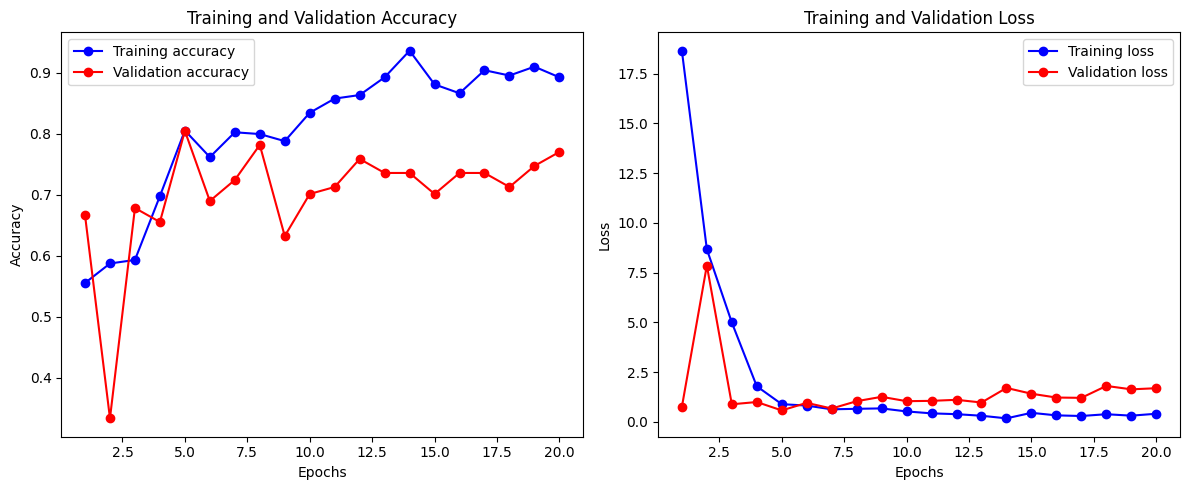

In [ ]:
# --- Plotting Training and Validation Metrics ---
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# --- After the training loop ---

# Define the path where you want to save the model
model_save_path = 'wound_classification_model_v2.pth'

# # Save the state dictionary of the trained model
# torch.save(model.state_dict(), model_save_path)

# print(f"\nModel saved successfully to: {model_save_path}")

# --- Later, to load the model ---
# Create an instance of your model architecture
loaded_model = ALPNet(input_size=input_size, num_classes=num_classes)

# Load the saved state dictionary
loaded_model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode if you intend to use it for inference
loaded_model.eval()

Calculated flattened size: 200704


ALPNet(
  (prep): Sequential(
    (0): Conv1d(3, 32, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Sequential(
      (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), groups=32, bias=False)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
      (3): Conv1d(32, 64, kernel_size=(1,), stride=(1,), bias=False)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SiLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), groups=64, bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
      (3): Conv1d(64, 64, kernel_size=(1

In [9]:
# --- Prediction Function ---
def predict_image(image_path, model, transform, class_names, device):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
        predicted_class_name = class_names[predicted_class.item()]
    return confidence.item(), predicted_class_name, os.path.splitext(os.path.basename(image_path))[0].split('_')[0] # Remove numbers and extension

### Assistant Setup

In [10]:
from langchain import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Pinecone
import pinecone
from pinecone import Pinecone
from langchain.document_loaders import PyPDFLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain.llms import CTransformers
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

PINECONE_API_KEY = "pcsk_25mGEG_38SLB2BbJDvvtkHN2V8NCK2MP9yyyFnm5e7U9tGB7SnJoJVjAbVnpR6nYtDn9qA"

# Extract data from the PDF
def load_pdf(data):
    loader = DirectoryLoader(data,
                             glob="*.pdf",
                             loader_cls=PyPDFLoader)

    documents = loader.load()

    return documents

extracted_data = load_pdf("data/")

# Create text chunks
def text_split(extracted_data):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=20)
    text_chunks = text_splitter.split_documents(extracted_data)

    return text_chunks

text_chunks = text_split(extracted_data)
print("length of my chunk:", len(text_chunks))

# Download embedding model
def download_hugging_face_embeddings():
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    return embeddings

import sentence_transformers
embeddings = download_hugging_face_embeddings()
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key=PINECONE_API_KEY)

index_name = "medical-assistant"

try:
    pc.describe_index(index_name)
    print(f"Index '{index_name}' already exists.")
except pinecone.exceptions.NotFoundException:
    pc.create_index(
        name=index_name,
        dimension=384,
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )
    print(f"Index '{index_name}' created successfully.")

import os
os.environ["PINECONE_API_KEY"] = PINECONE_API_KEY
from langchain_pinecone import PineconeVectorStore

try:
    docsearch = PineconeVectorStore.from_existing_index(
        index_name=index_name,
        embedding=embeddings
    )
    print(f"Successfully loaded existing index '{index_name}'.")
except Exception as e:
    print(f"Error loading existing index: {e}. Creating new index.")
    docsearch = PineconeVectorStore.from_documents(
        documents=text_chunks,
        index_name=index_name,
        embedding=embeddings
    )
    print(f"New index '{index_name}' created and populated.")

retriever = docsearch.as_retriever(search_type="similarity", search_kwargs={"k": 2})
retrieved_docs = retriever.invoke("What is Acne?")
print("Retrieved documents:", retrieved_docs)

c:\Users\anura\anaconda3\envs\healthcare_assistant\Lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


length of my chunk: 37362


C:\Users\anura\AppData\Local\Temp\ipykernel_24200\233647308.py:41: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


Index 'medical-assistant' already exists.
Successfully loaded existing index 'medical-assistant'.
Retrieved documents: [Document(id='3c418930-fe0d-4f12-99b1-402b94374b02', metadata={'page': 39.0, 'source': 'data\\Gale Encyclopedia of Medicine Vol. 1 (A-B).pdf'}, page_content='GALE ENCYCLOPEDIA OF MEDICINE 226\nAcne\nGEM - 0001 to 0432 - A  10/22/03 1:41 PM  Page 26'), Document(id='d1d7389f-7bf3-4f54-a1aa-2a41ffefb055', metadata={'page': 38.0, 'source': 'data\\Gale Encyclopedia of Medicine Vol. 1 (A-B).pdf'}, page_content='GALE ENCYCLOPEDIA OF MEDICINE 2 25\nAcne\nAcne vulgaris affecting a woman’s face. Acne is the general\nname given to a skin disorder in which the sebaceous\nglands become inflamed.(Photograph by Biophoto Associ-\nates, Photo Researchers, Inc. Reproduced by permission.)\nGEM - 0001 to 0432 - A  10/22/03 1:41 PM  Page 25')]


In [11]:
# Testing the model

# Load your local LLM model
def load_local_llm(model_path):
    llm = CTransformers(
        model=model_path,
        model_type="llama",
        config={'max_new_tokens': 256, 'temperature': 0.0}
    )
    return llm

llm_model_path = "model/llama-2-7b-chat.ggmlv3.q8_0.bin"
llm = load_local_llm(llm_model_path)

# Create the RAG chain
system_prompt = (
    "You are an assistant for question-answering tasks."
    "Use the following pieces of retrieved context to answer "
    "the question. If the user mentions that the situation is critical or an emergency, "
    "list out remedies in simple steps that the user should take to deal with the emergency. "
    "Otherwise, provide a normal answer. In all cases, format the answer neatly and clearly."
    "If you don't know the answer, say that you don't know."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)
questions_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, questions_answer_chain)

# Invoke the RAG chain
query = "What is Acne?"
response = rag_chain.invoke({"input": query})

print("RAG Response:", response["answer"])

Number of tokens (513) exceeded maximum context length (512).
Number of tokens (514) exceeded maximum context length (512).
Number of tokens (515) exceeded maximum context length (512).
Number of tokens (516) exceeded maximum context length (512).
Number of tokens (517) exceeded maximum context length (512).
Number of tokens (518) exceeded maximum context length (512).
Number of tokens (519) exceeded maximum context length (512).
Number of tokens (520) exceeded maximum context length (512).
Number of tokens (521) exceeded maximum context length (512).
Number of tokens (522) exceeded maximum context length (512).
Number of tokens (523) exceeded maximum context length (512).
Number of tokens (524) exceeded maximum context length (512).
Number of tokens (525) exceeded maximum context length (512).
Number of tokens (526) exceeded maximum context length (512).
Number of tokens (527) exceeded maximum context length (512).
Number of tokens (528) exceeded maximum context length (512).
Number o

RAG Response: 
Assistant: Hello! I'm here to help you with your question. Acne is a common skin condition that occurs when the pores on the skin become clogged with dead skin cells, oil, and bacteria. It can cause whiteheads, blackheads, and inflamed red pimples on the face, as well as other areas of the body. There are several types of acne, including acne vulgaris, which is the most common form, and cystic acne, which is a more severe and painful form of the condition. Acne can be caused by a variety of factors, including hormonal changes, genetics, and environmental factors such as stress and humidity. Treatment options for acne include topical creams and gels, oral antibiotics and retinoids, and lifestyle changes such as using non-comedogenic products and avoiding picking or popping pimples. If you are experiencing severe or persistent acne, it is important to deal with no, I don'ne, it is recommended that is a, it is best treatment, it is important to help, it is important to deal

In [12]:
# Load your local LLM model
def load_local_llm(model_path):
    llm = CTransformers(
        model=model_path,
        model_type="llama",
        config={'max_new_tokens': 500, 'temperature': 0.2}
    )
    return llm

llm_model_path = "model/llama-2-7b-chat.ggmlv3.q8_0.bin"
llm = load_local_llm(llm_model_path)

# Create the RAG chain
system_prompt = (
    "You are an assistant for question-answering tasks."
    "Use the following pieces of retrieved context to answer "
    "the question. If the user mentions that the situation is critical or an emergency, "
    "list out remedies in simple steps that the user should take to deal with the emergency. "
    "Otherwise, provide a normal answer. In all cases, format the answer neatly and clearly."
    "If you don't know the answer, say that you don't know."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)
questions_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, questions_answer_chain)

### Setting-Up Assistant Voice

In [13]:
# step1a: Text to Speech-TTS-model (with gTTS)

import os
from gtts import gTTS
import subprocess
import platform

def text_to_speech_with_gtts(input_text, output_filepath):
    language="en"

    audioobj=gTTS(
        text=input_text,
        lang=language,
        slow=False
    )
    audioobj.save(output_filepath)

    os_name = platform.system()
    try:
        if os_name == "Darwin":
            subprocess.run(['afplay', output_filepath])
        elif os_name == "Windows":
            subprocess.run(['ffplay', '-nodisp', '-autoexit', output_filepath],
                           stdout=subprocess.DEVNULL,
                           stderr=subprocess.DEVNULL
                           )
        elif os_name == "Linux":
            subprocess.run(['aplay', output_filepath])
        else:
            raise OSError("Unsupported operating system")
    except Exception as e:
        print(f"An error occured while trying to play the audio: {e}")

input_text="Hi this is AI with Anurag, autoplay testing"
# text_to_speech_with_gtts(input_text=input_text, output_filepath="gtts_testing_autoplay.mp3")


### Final Running

In [17]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Assume you have your EmotionLandmarkNet class defined in this script

# Load your trained model (replace with your actual parameters)
input_size = 224 * 224 * 3
num_classes = 2
model = ALPNet(input_size=input_size, num_classes=num_classes)
model_path = 'wound_classification_model_v2.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    model.to(device)
    print("Model loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model not found at {model_path}")
    exit()

# Define your class names
class_names = ['critical', 'non_critical']

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def clean_filename(filename):
    """Removes numbers and special characters from a filename base."""
    cleaned_name = re.sub(r'[^a-zA-Z_]', '', filename)
    return cleaned_name

def predict_single_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor)
            probabilities = torch.softmax(output, dim=1)
            confidence, predicted_class = torch.max(probabilities, 1)
            
            # Check confidence score threshold
            confidence_score = confidence.item()
            # if confidence_score < 0.7:  # Threshold set to 70%
            #     # Flip to the other class
            #     predicted_class = 1 - predicted_class
            #     confidence_score = 1.0 - confidence_score
            
            predicted_class_name = class_names[predicted_class.item()]
        
        filename_base = os.path.splitext(os.path.basename(image_path))[0]
        cleaned_filename = clean_filename(filename_base)
        return confidence_score, predicted_class_name, cleaned_filename, image
    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return None, None, None, None
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None, None, None


Calculated flattened size: 200704
Model loaded successfully.


In [18]:
# # Invoke the RAG chain with user input
# while True:
#     query = input("Ask a question about the medical documents (or type 'exit' to quit): ")
#     if query.lower() == 'exit':
#         break

#     response = rag_chain.invoke({"input": query})
#     print("RAG Response:", response["answer"])

# print("Exiting the question-answering session.")


Options:
1: Image-based input
2: Text-based input
3: Both image and text-based input
4: Exit

--- Prediction Result ---
Filename: abrasions
Predicted Class: non_critical
Confidence: 1.0000


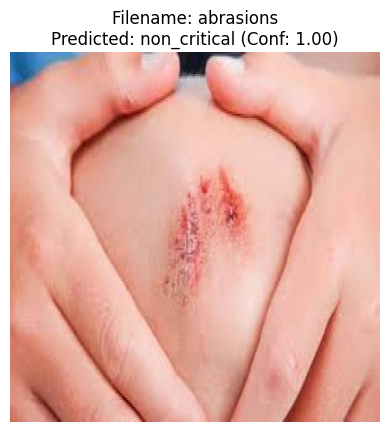

Number of tokens (513) exceeded maximum context length (512).
Number of tokens (514) exceeded maximum context length (512).
Number of tokens (515) exceeded maximum context length (512).
Number of tokens (516) exceeded maximum context length (512).
Number of tokens (517) exceeded maximum context length (512).
Number of tokens (518) exceeded maximum context length (512).
Number of tokens (519) exceeded maximum context length (512).
Number of tokens (520) exceeded maximum context length (512).
Number of tokens (521) exceeded maximum context length (512).
Number of tokens (522) exceeded maximum context length (512).
Number of tokens (523) exceeded maximum context length (512).
Number of tokens (524) exceeded maximum context length (512).
Number of tokens (525) exceeded maximum context length (512).
Number of tokens (526) exceeded maximum context length (512).
Number of tokens (527) exceeded maximum context length (512).
Number of tokens (528) exceeded maximum context length (512).
Number o

RAG Response: 
Assistant: Of course! An abrasion is a type of injury that occurs when the skin is scraped or rubbed, resulting in lines of scraped skin and tiny spots of bleeding. Treatment for an abrasion typically involves keeping the area clean and dry, applying antibiotic ointment to prevent infection, and avoiding any strenuous activities that could dislodge the healing tissue. If the abrasion is severe or covers a large area of the eye, your doctor may recommend further treatment, such as a corneal transplant. It's important to note critical or not an important to help if you noticeable to be best to determine the situation is important to seeks important to important to important to important to important to important to ensure that helpful to minimally important to note critical to assessmentioned that you experience,s important to keep in important to important to important to important to important to important to important to important to important to important to be best to

In [19]:
if __name__ == "__main__":
    query = ""

    while True:
        print("\nOptions:")
        print("1: Image-based input")
        print("2: Text-based input")
        print("3: Both image and text-based input")
        print("4: Exit")

        try:
            choice = int(input("Select an option (1-4): "))
        except ValueError:
            print("Invalid input. Please enter a number between 1 and 4.")
            continue

        match choice:
            case 1:  # Image-based input
                image_path = input("Enter the full path to the image file you want to predict: ")

                if not os.path.exists(image_path):
                    print(f"Error: Image file not found at {image_path}")
                elif not image_path.lower().endswith(('.jpeg', '.jpg', '.png')):
                    print("Error: Please enter a valid JPEG, JPG, or PNG image file.")
                else:
                    confidence, predicted_class, filename_base, image = predict_single_image(image_path)
                    if confidence is not None:
                        print("\n--- Prediction Result ---")
                        print(f"Filename: {filename_base}")
                        print(f"Predicted Class: {predicted_class}")
                        print(f"Confidence: {confidence:.4f}")

                        # Display the image using Matplotlib
                        plt.figure()
                        plt.imshow(image)
                        plt.title(f"Filename: {filename_base}\nPredicted: {predicted_class} (Conf: {confidence:.2f})")
                        plt.axis('off')  # Turn off axis numbers and ticks
                        plt.show()

                        query = f"{predicted_class}, {filename_base}"

            case 2:  # Text-based input
                query = input("Ask a question about the medical documents (or type 'exit' to quit): ")

            case 3:  # Both image and text-based input
                image_path = input("Enter the full path to the image file you want to predict: ")

                if not os.path.exists(image_path):
                    print(f"Error: Image file not found at {image_path}")
                elif not image_path.lower().endswith(('.jpeg', '.jpg', '.png')):
                    print("Error: Please enter a valid JPEG, JPG, or PNG image file.")
                else:
                    confidence, predicted_class, filename_base, image = predict_single_image(image_path)
                    if confidence is not None:
                        print("\n--- Prediction Result ---")
                        print(f"Filename: {filename_base}")
                        print(f"Predicted Class: {predicted_class}")
                        print(f"Confidence: {confidence:.4f}")

                        # Display the image using Matplotlib
                        plt.figure()
                        plt.imshow(image)
                        plt.title(f"Filename: {filename_base}\nPredicted: {predicted_class} (Conf: {confidence:.2f})")
                        plt.axis('off')  # Turn off axis numbers and ticks
                        plt.show()

                text_query = input("Ask a question about the medical documents (or type 'exit' to quit): ")
                query = f"{predicted_class}, {filename_base}, {text_query}"

            case 4:  # Exit
                print("Exiting the question-answering session.")
                break

            case _:  # Default case for invalid inputs
                print("Invalid selection. Please select a valid option.")

        if query:
            response = rag_chain.invoke({"input": query})
            print("RAG Response:", response["answer"])
        
        text_to_speech_with_gtts(input_text=response["answer"], output_filepath="gtts_output_file.mp3")